**<h2>한글 오토마타 만들기 </h2>**

---


<br><h3>1. 한글 도메인 지식</h3>

* 한글은 음절단위로 음절은 초성-중성-종성으로 이루어 진다.
* 한글은 단어와 단어 사이는 빈칸을 하나씩 넣어야 한다.
* 음절의 경우에는 초성-중성, 초성-중성-종성은 가능하지만 초성이 없는 경우는 불가능하고, 중성도 꼭 필요하다.
* 이러한 단어 단위는 연속적으로 이어지게 되는 오토마타를 이루게 된다.

<br><h3>2. 한글의 자음은 17개, 모음은 11개로 구성되어 있습니다. 초성, 중성, 종성에서는 다음의 문자가 사용됩니다.</h3>

* 한글 초성 : 19개 (ㄱ ㄲ ㄴ ㄷ ㄸ ㄹ ㅁ ㅂ ㅃ ㅅ ㅆ ㅇ ㅈ ㅉ ㅊ ㅋ ㅌ ㅍ ㅎ)
* 한글 중성 : 21개 (ㅏ ㅐ ㅑ ㅒ ㅓ ㅔ ㅕ ㅖ ㅗ ㅘ ㅙ ㅚ ㅛ ㅜ ㅝ ㅞ ㅟ ㅠ ㅡ ㅢ ㅣ)
* 한글 종성 : 28개 ((없음) ㄱ ㄲ ㄳ ㄴ ㄵ ㄶ ㄷ ㄹ ㄺ ㄻ ㄼ ㄽ ㄾ ㄿ ㅀ ㅁ ㅂ ㅄ ㅅ ㅆ ㅇ ㅈ ㅊ ㅋ ㅌ ㅍ ㅎ)


<br><h3>3. 다음 가능 문자열과 불가능 문자열을 한글 오토마타로 표현하고 입력하면 가능한지 불가능한지를 알려주어야 함.</h3>
* 가능 문자열: 가, 나, 다, 간, 난, 단, 갊, 낢, 닮, 집에 간다,…..
* 불가능 문자열: ㄱ, ㄴ, ㄷ, ㅓ, ㅏ, ㅙ, ㅞ, 갈ㄷ, 닭ㄱ, 구ㅐ, 괳ㄴ, ㅏㅣ,집ㅂ에다 …….
* 문장단위도 가능: 나는 이화여자대학교 학생이다(o), 나는 이화여자대ㅎ학교 ㅎㅎ학생(x)


<br><h3>4. 특수문자, 숫자, 빈칸이 input_string에 들어올 경우: epsilon으로 간주</h3>
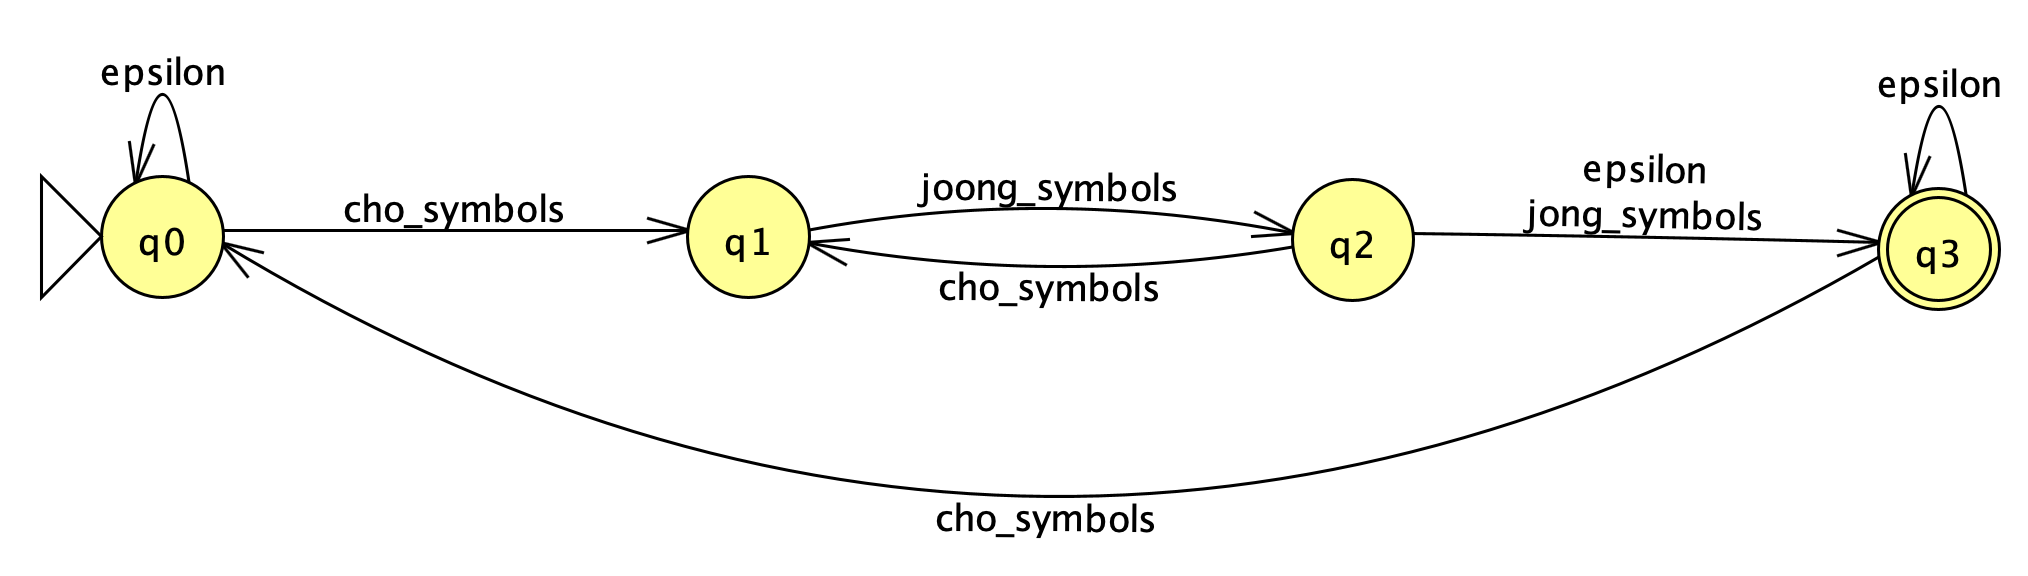

<br>

---
<br>






In [1]:
# pyformlang 모듈 설치하기
!pip install pyformlang

# 한글 모듈 설치하기
!pip install hgtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.4 MB/s eta 0:00:00


In [4]:
import hgtk
from pyformlang.finite_automaton import EpsilonNFA, State, Symbol, Epsilon

# hgtk.letter 모듈에서 제공하는 한글 초성, 중성, 종성 리스트 활용
epsilon = Epsilon()
cho_list = hgtk.letter.CHO
joong_list = hgtk.letter.JOONG
jong_list = hgtk.letter.JONG[1:]
blank = Symbol(" ")

# 특수문자, 숫자, 빈칸이 input_string에 들어올 경우: epsilon으로 간주
special_char_ranges = [
    range(0x21, 0x30),  # ! to /
    range(0x3A, 0x41),  # : to @
    range(0x5B, 0x61),  # [ to `
    range(0x7B, 0x7F)   # { to ~
]
char_as_epsilon = [chr(x) for r in special_char_ranges for x in r] # 특수문자 추가
char_as_epsilon.extend(str(x) for x in range(10)) # 숫자 추가
char_as_epsilon.append(' ') # 빈칸 추가

# symbol + state 선언
cho_symbols = [Symbol(cho) for cho in cho_list]
joong_symbols = [Symbol(jung) for jung in joong_list]
jong_symbols = [Symbol(jong) for jong in jong_list]
states = [State("q" + str(x)) for x in range(4)]

# Epsilon NFA 생성
enfa = EpsilonNFA()
enfa.add_start_state(states[0]) # q0 : initial state
enfa.add_final_state(states[3]) # q3 : final state

enfa.add_transition(states[0], epsilon, states[0]) # 특수문자, 숫자, 빈칸이 epsilon으로 간주된 것
enfa.add_transition(states[3], epsilon, states[3]) # 특수문자, 숫자, 빈칸이 epsilon으로 간주된 것
enfa.add_transition(states[2], epsilon, states[3]) # 종성이 없는 경우 final state로 보내기!

for cho_sung in cho_symbols:
    enfa.add_transition(states[0], cho_sung, states[1])
    enfa.add_transition(states[3], cho_sung, states[1])
    enfa.add_transition(states[2], cho_sung, states[1])

for joong_sung in joong_symbols:
    enfa.add_transition(states[1], joong_sung, states[2])

for jong_sung in jong_symbols:
    enfa.add_transition(states[2], jong_sung, states[3])

# 입력 문자열 -> 심볼 리스트
def decompose_and_symbolize(input_string, compose_code=''):
    # 입력 문자열을 분해합니다.
    decomposed_string = hgtk.text.decompose(input_string, compose_code=compose_code)

    symbol_list = []
    for char in decomposed_string:
        if char in char_as_epsilon:  # 특수문자, 숫자, 빈칸(공백) 감지
            symbol_list.append(epsilon)  # epsilon을 리스트에 추가
        elif char:
            symbol_list.append(Symbol(char))
    return symbol_list

# 입력 문자열이 한글로 이루어졌는지 확인!
def is_accepted_by_korean_automaton(input_string):
    symbol_list = decompose_and_symbolize(input_string)
    return enfa.accepts(symbol_list)

# 문자열 test 및 결과 출력 함수
def test_string_and_print_result(input_string):
    result = is_accepted_by_korean_automaton(input_string)
    return print(f"문자열 '{input_string}': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!" if result else f"문자열 '{input_string}': 한글로 이루어진 문자열이 아님!")

# test할 입력 문자열을 배열에 넣고 test_string() 함수 반복
input_strings = [
    "가", "나", "다", "간", "난", "단",
    "갊", "낢", "닮", "집에 간다", "ㄱ",
    "ㄴ", "ㄷ", "ㅓ", "ㅏ", "ㅙ", "ㅞ",
    "갈ㄷ", "닭ㄱ", "구ㅐ", "괳ㄴ", "ㅏㅣ",
    "집ㅂ에다", "나는 25살이다.",
    "나는 이화여자대학교 학생이다",
    "나는 이화여자대ㅎ학교 ㅎㅎ학생"
]

for input_string in input_strings:
  test_string_and_print_result(input_string)


문자열 '가': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '나': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '다': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '간': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '난': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '단': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '갊': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '낢': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '닮': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '집에 간다': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 'ㄱ': 한글로 이루어진 문자열이 아님!
문자열 'ㄴ': 한글로 이루어진 문자열이 아님!
문자열 'ㄷ': 한글로 이루어진 문자열이 아님!
문자열 'ㅓ': 한글로 이루어진 문자열이 아님!
문자열 'ㅏ': 한글로 이루어진 문자열이 아님!
문자열 'ㅙ': 한글로 이루어진 문자열이 아님!
문자열 'ㅞ': 한글로 이루어진 문자열이 아님!
문자열 '갈ㄷ': 한글로 이루어진 문자열이 아님!
문자열 '닭ㄱ': 한글로 이루어진 문자열이 아님!
문자열 '구ㅐ': 한글로 이루어진 문자열이 아님!
문자열 '괳ㄴ': 한글로 이루어진 문자열이 아님!
문자열 'ㅏㅣ': 한글로 이루어진 문자열이 아님!
문자열 '집ㅂ에다': 한글로 이루어진 문자열이 아님!
문자열 '나는 25살이다.': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '나는 이화여자대학교 학생이다': 한글 오토마타로 표현 가능. 한글로 이루어진 문자열임!
문자열 '나는 이화여자대ㅎ학교 ㅎㅎ학생': 한글로 이루어진 문자열이 아님!
